In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt

# EDA

In [60]:
df = pd.read_csv('./datasets/abalone data.csv', header=None)
df.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
df['age_cont'] = df['rings'].map(lambda v: v + 1.5)

In [61]:
df.head(2)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age_cont
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,8.5


In [62]:
print("Number and names of features:", len(df.columns) - 1, set(df.columns) - {'age', 'rings'})
print("Number of data points:", df.shape[0])

Number and names of features: 9 {'shucked_weight', 'shell_weight', 'viscera_weight', 'height', 'age_cont', 'whole_weight', 'length', 'sex', 'diameter'}
Number of data points: 4177


As we are performing classification in this Lab, we will categorize the target feature, which is a numerical-ratio feature, into three classes. Specifically, abalones with an age of less than 10 years will belong to one class, abalones with age between 10 and 15 will belong to the second class, while abalones older than 15 years will be part of the third class. The selection of 10 and 15 years as the thresholds is somewhat arbitrary, although it is chosen based on the quartiles of the age attribute.

C:\Users\User\AppData\Local\Temp\ipykernel_18768\966182228.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


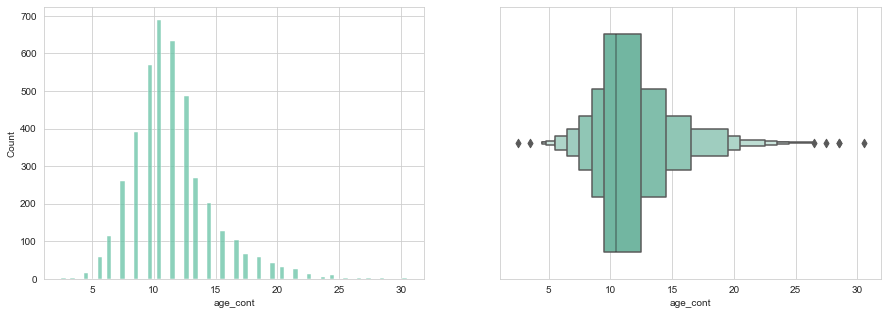

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x='age_cont', ax=ax[0])
sns.boxenplot(data=df, x='age_cont', ax=ax[1])
fig.show()

In [64]:
bins = [0, 10, 15, 100]
labels = ['<10', '10-15', '>15']
df['age'] = pd.cut(df['age_cont'], bins=bins, labels=labels)

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='count'>

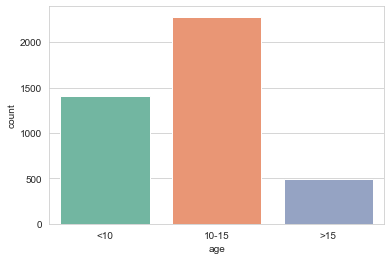

In [65]:
sns.countplot(df['age'])

In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
whole_weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
shucked_weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
viscera_weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
shell_weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000
age_cont,4177.0,11.433684,3.224169,2.5000,9.5000,10.5000,12.500,30.5000


The "sex" attribute could be a good predictor for the target variable, but the classifiers used in this homework assume normally distributed data, hence we cannot use it.

In [67]:
df['sex'].value_counts()

M    1528
I    1342
F    1307
Name: sex, dtype: int64

<AxesSubplot:xlabel='sex', ylabel='count'>

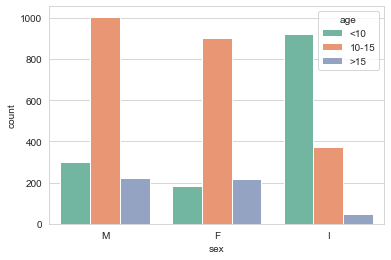

In [68]:
sns.countplot(data=df, x='sex', hue='age')

The non-normal distributions of the numerical variables pose a challenge since Gaussian NB, LA, and QDA require the conditional probabilities $p(\mathbf{x} | y=c, \mathbf{\theta})$ to follow a multivariate normal distribution.

In [69]:
ratio_features = [col for col in df.columns if df[col].dtype == 'float64' and col != 'age_cont']

C:\Users\User\AppData\Local\Temp\ipykernel_18768\3766839930.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[ratio_features].hist(ax = ax, bins=30)


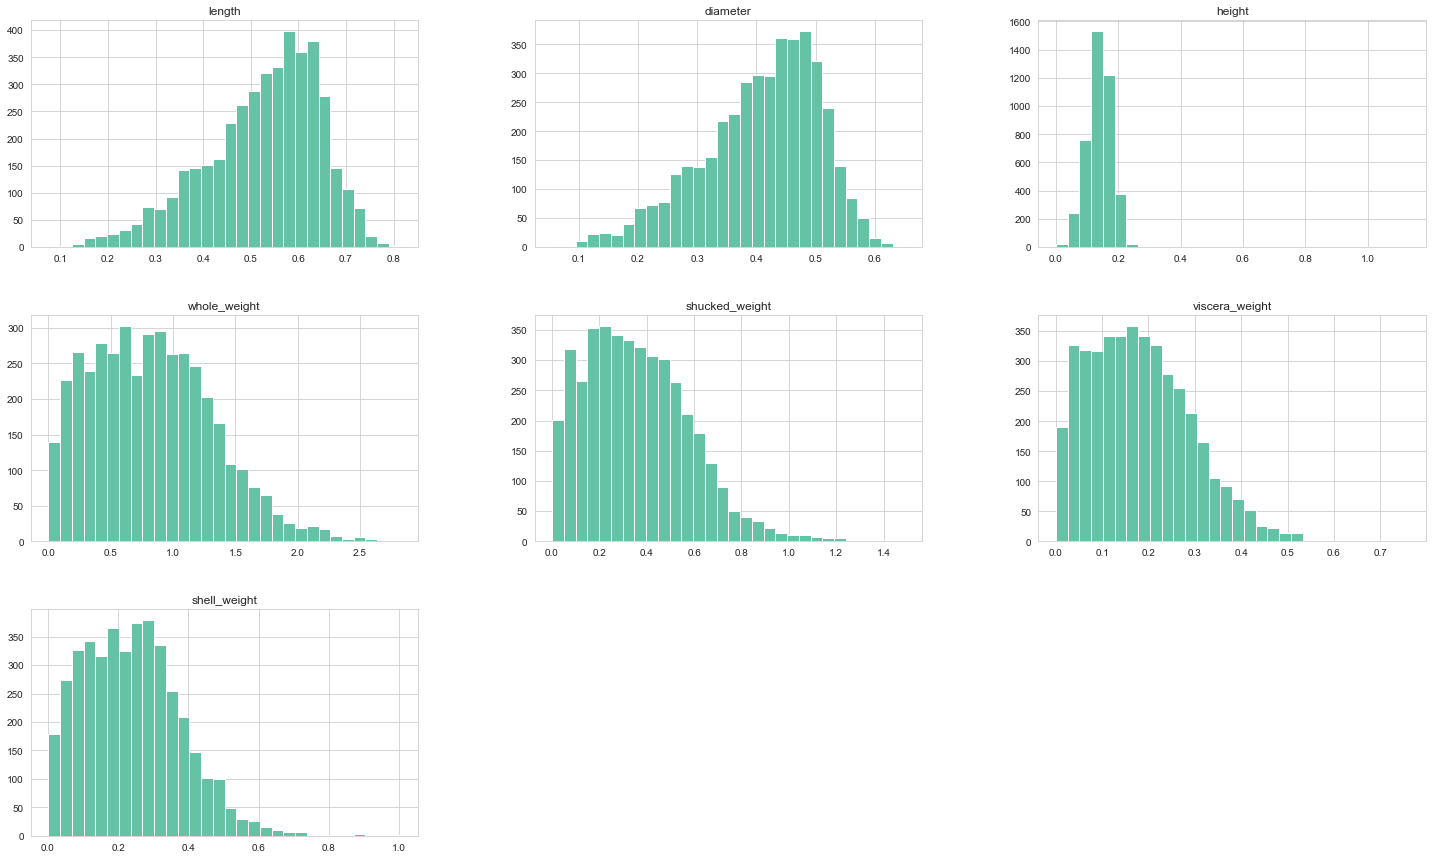

In [70]:
ax = plt.figure(figsize=(25, 15))
df[ratio_features].hist(ax = ax, bins=30)
plt.show()

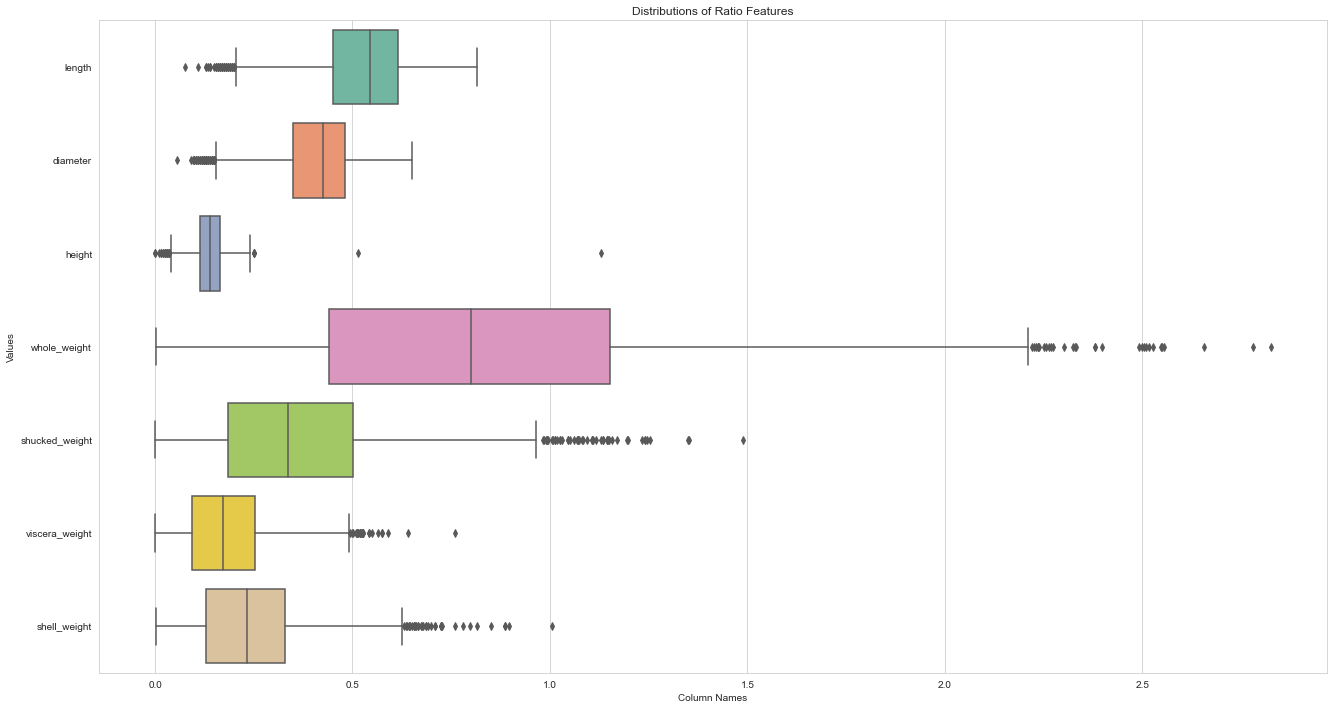

In [71]:
plt.figure(figsize=(22, 12))
ax = sns.boxplot(data=df[ratio_features], orient='h')

ax.set_title('Distributions of Ratio Features')
ax.set_xlabel('Column Names')
ax.set_ylabel('Values')

plt.show()

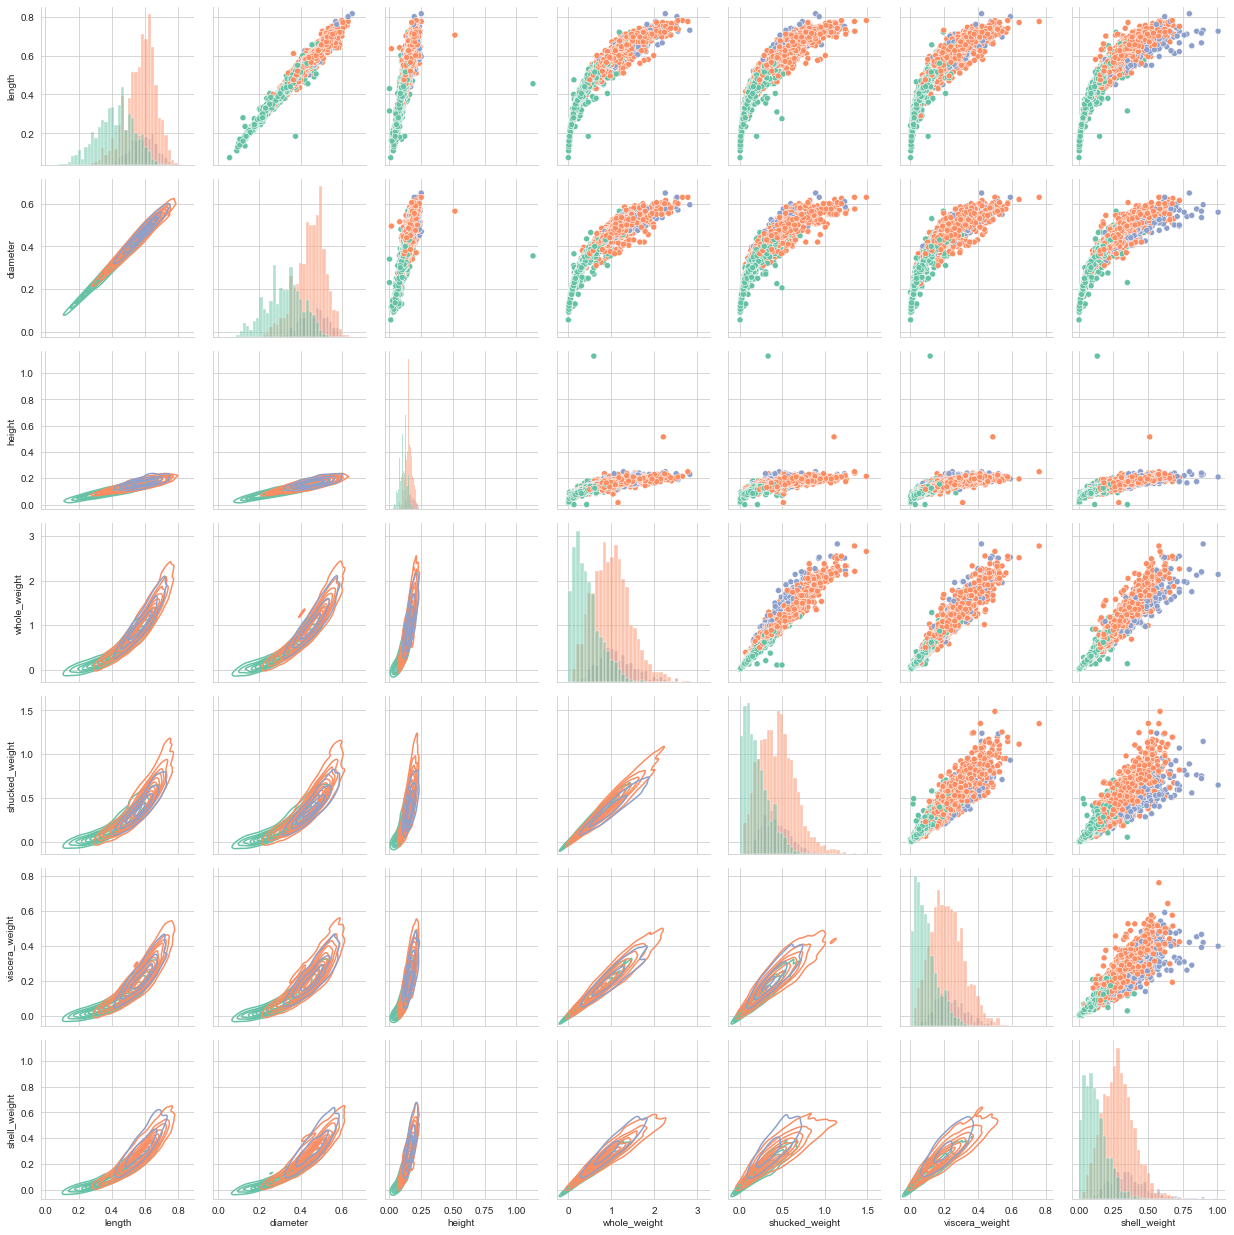

In [72]:
g = sns.PairGrid(df[ratio_features + ['age']], diag_sharey=False, hue='age')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)

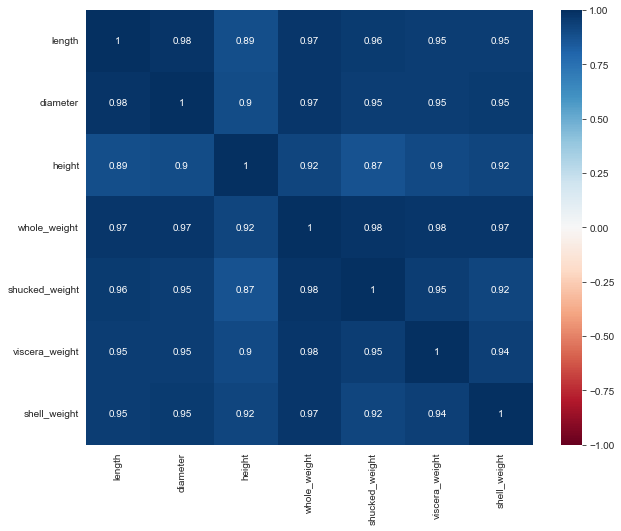

In [73]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[ratio_features].corr(method='spearman'),
    cmap='RdBu',
    annot=True,
    vmin=-1,
    vmax=1
)
plt.show()

To avoid model overconfidence (particularly in Naive Bayes), it may be advisable to eliminate some of the highly correlated features.

In [74]:
df_dropped = df.drop(['sex', 'shucked_weight', 'viscera_weight', 'shell_weight', 'age_cont', 'rings'], axis=1, inplace=False)

In [75]:
df_dropped.columns

Index(['length', 'diameter', 'height', 'whole_weight', 'age'], dtype='object')

# Classification

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [77]:
def plot_metrics_per_class(y, y_pred, ax, horizontal=True):
    index = sorted(y.unique().tolist())

    # when there is a zero division, precision is set to 0
    precision = pd.Series(precision_score(y, y_pred, average=None, zero_division=0, labels=index), index=index)
    recall = pd.Series(recall_score(y, y_pred, average=None, labels=index), index=index)
    f1 = pd.Series(f1_score(y, y_pred, average=None, labels=sorted(y.unique().tolist())), index=index)

    results = pd.DataFrame(pd.concat([precision, recall, f1], axis=1))
    results.columns = ['precision', 'recall', 'f1']

    if horizontal:
        sns.heatmap(results.T, vmin=0, vmax=1, cmap='Greens', annot=True, ax=ax)
    else:
        sns.heatmap(results, vmin=0, vmax=1, cmap='Greens', annot=True, ax=ax)

In [78]:
def get_scores(y, y_pred, average_type):
    data = []
    index = ['accuracy', f'precision ({average_type})', f'recall ({average_type})', f'f1 ({average_type})']

    data.append([accuracy_score(y, y_pred),
                 precision_score(y, y_pred, average=average_type, zero_division=0),
                 recall_score(y, y_pred, average=average_type),
                 f1_score(y, y_pred, average=average_type)])

    return pd.DataFrame(data, columns=index).T

In [79]:
def print_conf_matrices(train_y, test_y, pred_y_train, pred_y_test, model):
    cm_train = confusion_matrix(train_y, pred_y_train, normalize='true')
    cm_test = confusion_matrix(test_y, pred_y_test, normalize='true')
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(
        cm_train,
        annot=True,
        cmap='Greens',
        vmin=0,
        vmax=1,
        xticklabels=list(model.classes_),
        yticklabels=list(model.classes_),
        ax=ax[0]
    )
    sns.heatmap(
        cm_test,
        annot=True,
        cmap='Greens',
        vmin=0,
        vmax=1,
        xticklabels=list(model.classes_),
        yticklabels=list(model.classes_),
        ax=ax[1]
    )
    ax[0].set_title("CM for train set")
    ax[1].set_title("CM for test set")
    plt.show()

In [80]:
y = df_dropped['age'].copy()
X = df_dropped.drop('age', axis=1, inplace=False).copy()

# y = df['age'].copy()
# X = df.drop(['age', 'age_cont', 'rings', 'sex'], axis=1, inplace=False).copy()

In [81]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=123)

In [82]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(3341, 4) (836, 4) (3341,) (836,)


## Naive Bayes

In [83]:
nb = GaussianNB()
nb.fit(train_X, train_y)
y_pred_nb_train = nb.predict(train_X)
y_pred_nb_test = nb.predict(test_X)

The Naive Bayes model rests on the assumption that features are conditionally independent given the class, which poses limitations when the features are highly correlated (as in our case). As anticipated, the model struggles to identify feature vectors that belong to the ">15" class, likely due to its underrepresentation. Incorporating domain knowledge and priors and using the Bayesian Naive Bayes approach could potentially enhance the model's performance.

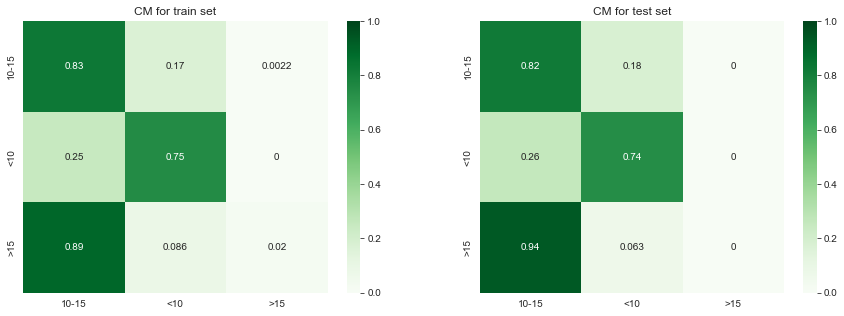

In [84]:
print_conf_matrices(train_y, test_y, y_pred_nb_train, y_pred_nb_test, nb)

In [104]:
pd.Series(y_pred_nb_test).value_counts()

10-15    534
<10      302
dtype: int64

In [85]:
get_scores(test_y, y_pred_nb_test, 'weighted')

,0
accuracy,0.697368
precision (weighted),0.618424
recall (weighted),0.697368
f1 (weighted),0.655001


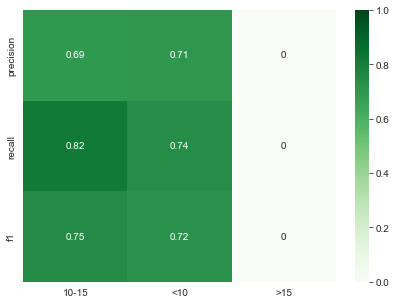

In [86]:
_, axis = plt.subplots(1, 1, figsize=(7, 5))
plot_metrics_per_class(test_y, y_pred_nb_test, axis)

## LDA

In [87]:
lda = LinearDiscriminantAnalysis()
lda.fit(train_X, train_y)
y_pred_lda_train = lda.predict(train_X)
y_pred_lda_test = lda.predict(test_X)

LDA shares the assumption with GNB that class conditional probabilities follow a normal distribution, but also assumes that the covariance matrices are equal across classes, which is hardly the case in this particular problem. Due to the non-normal distribution of the data, the estimated parameters assume normality and inadequately describe the empirical distributions, resulting in similar outcomes to those of the Naive Bayes classifier.

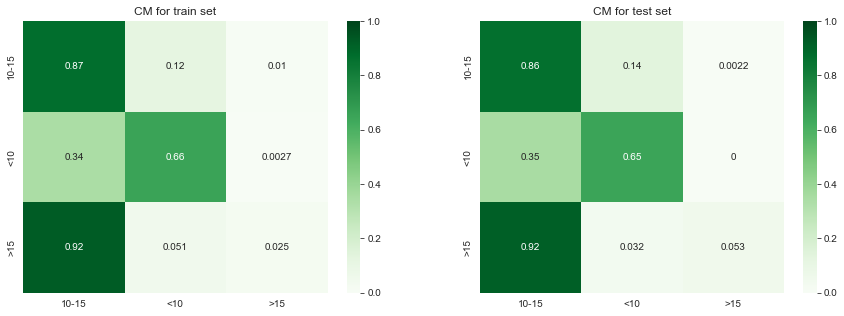

In [88]:
print_conf_matrices(train_y, test_y, y_pred_lda_train, y_pred_lda_test, lda)

In [102]:
pd.Series(y_pred_lda_test).value_counts()

10-15    578
<10      252
>15        6
dtype: int64

In [89]:
get_scores(test_y, y_pred_lda_test, 'weighted')

,0
accuracy,0.696172
precision (weighted),0.715955
recall (weighted),0.696172
f1 (weighted),0.659795


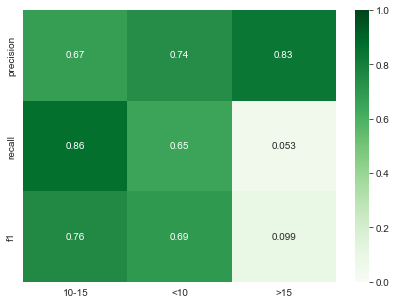

In [90]:
_, axis = plt.subplots(1, 1, figsize=(7, 5))
plot_metrics_per_class(test_y, y_pred_lda_test, axis)

## QDA

QDA faces similar challenges as LDA, with the exception that it does not assume shared covariance matrices across classes. Instead, QDA estimates full covariance matrices for each class conditional probability distribution. However, due to the violation of the multivariate normal assumption, the resulting estimates are inadequate.

In [91]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(train_X, train_y)
y_pred_qda_train = qda.predict(train_X)
y_pred_qda_test = qda.predict(test_X)

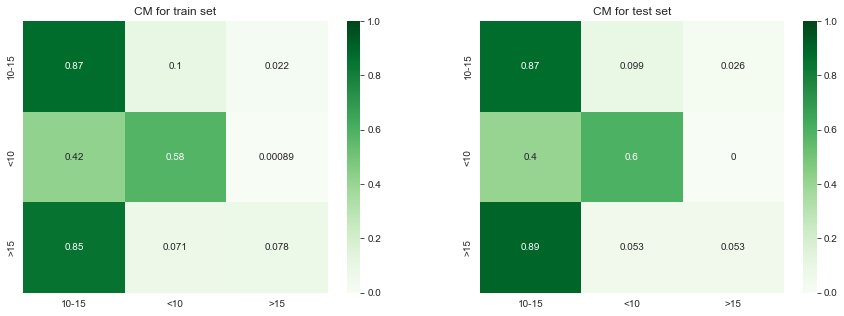

In [92]:
print_conf_matrices(train_y, test_y, y_pred_qda_train, y_pred_qda_test, qda)

In [103]:
pd.Series(y_pred_qda_test).value_counts()

10-15    597
<10      222
>15       17
dtype: int64

In [93]:
get_scores(test_y, y_pred_qda_test, 'weighted')

,0
accuracy,0.685407
precision (weighted),0.659759
recall (weighted),0.685407
f1 (weighted),0.651235


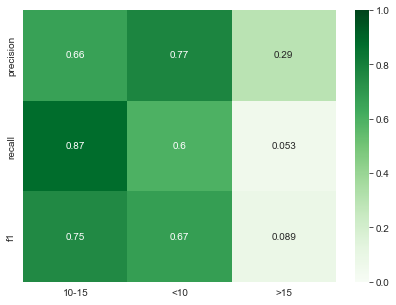

In [94]:
_, axis = plt.subplots(1, 1, figsize=(7, 5))
plot_metrics_per_class(test_y, y_pred_qda_test, axis)

## QDA With priors

In [95]:
qda_2 = QuadraticDiscriminantAnalysis(priors=[0.3, 0.4, 0.3]) # The priors are chosen randomly, since I do not have any domain knowledge
qda_2.fit(train_X, train_y)
y_pred_qda_2_train = qda_2.predict(train_X)
y_pred_qda_2_test = qda_2.predict(test_X)

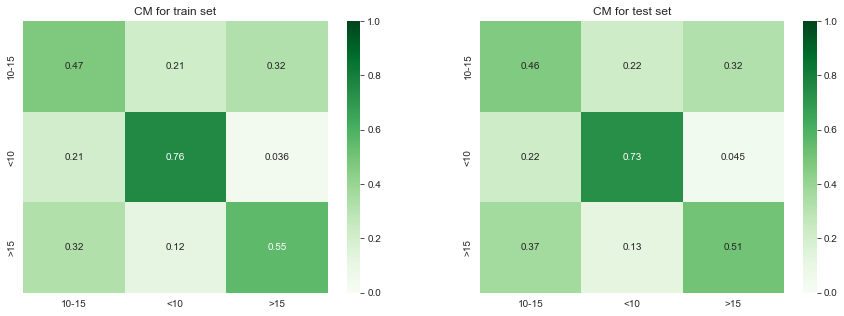

In [96]:
print_conf_matrices(train_y, test_y, y_pred_qda_2_train, y_pred_qda_2_test, qda_2)

In [105]:
pd.Series(y_pred_qda_2_test).value_counts()

<10      323
10-15    308
>15      205
dtype: int64

In [97]:
get_scores(test_y, y_pred_qda_2_test, 'weighted')

,0
accuracy,0.559809
precision (weighted),0.619346
recall (weighted),0.559809
f1 (weighted),0.571933


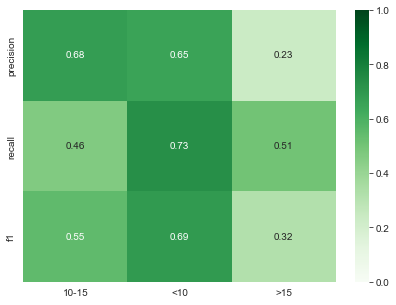

In [98]:
_, axis = plt.subplots(1, 1, figsize=(7, 5))
plot_metrics_per_class(test_y, y_pred_qda_2_test, axis)

Additional insights into the dataset could explain why the features are not optimal predictors of the target variable, but it's worth noting that we did not utilize one of the variables (Sex) and that further feature engineering may be necessary. While I initially anticipated that QDA would yield the best performance due to its fewer assumptions, the results indicated otherwise. The violation of the normality assumption had a significant impact, preventing the models from learning an accurate representation of the data.